In [229]:
import itertools
import json
import os
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pca
import requests
from photutils.utils import ShepardIDWInterpolator
import rasterio.transform as rio_transform
import rasterio as rio
import rasterio.mask as rio_mask

In [171]:
data_path = Path(os.environ["DATA_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
segregation_path = Path(os.environ["SEGREGATION_PATH"])
census_path = Path(os.environ["CENSUS_PATH"])
geostatistical_framework_path = Path(os.environ["GEOSTATISTICAL_FRAMEWORK_PATH"])

# DataFrames

## Censo

In [172]:
df_census_base = pd.read_csv(
    census_path / "2020" / "08.csv",
    usecols=[
        "ENTIDAD",
        "MUN",
        "LOC",
        "AGEB",
        "MZA",
        "NOM_LOC",
        "POBTOT",
        "P_0A2",
        "P_3A5",
        "P_60YMAS",
        "P18YM_PB",
        "P_18YMAS",
        "GRAPROES",
        "TVIVPARHAB",
        "PRO_OCUP_C",
        "VPH_PISODT",
        "VPH_C_ELEC",
        "VPH_REFRI",
        "VPH_LAVAD",
        "VPH_HMICRO",
        "VPH_NDACMM",
    ],
)

## AGEBs

In [173]:
df_geom_agebs = (
    gpd.read_file(
        population_grids_path
        / "final"
        / "zone_agebs"
        / "shaped"
        / "2020"
        / "08.2.03.gpkg",
    )
    .drop(columns=["POBTOT"])
    .set_index("CVEGEO")
)

df_census_agebs = (
    df_census_base.query("NOM_LOC == 'Total AGEB urbana'")
    .assign(
        CVEGEO=lambda df: (
            df["ENTIDAD"].astype(str).str.zfill(2)
            + df["MUN"].astype(str).str.zfill(3)
            + df["LOC"].astype(str).str.zfill(4)
            + df["AGEB"].astype(str).str.zfill(4)
        ),
    )
    .drop(columns=["ENTIDAD", "MUN", "LOC", "AGEB", "NOM_LOC"])
    .set_index("CVEGEO")
    .replace("*", np.nan)
    .astype(float)
)

df = df_geom_agebs.join(df_census_agebs, how="inner").assign(
    P_0A5=lambda df: df["P_0A2"] + df["P_3A5"],
)

## Manzanas

In [174]:
df_geom_blocks = (
    gpd.read_file(geostatistical_framework_path / "2020" / "08_chihuahua" / "08m.shp")
    .assign(CVEGEO_AGEB=lambda x: x.CVEGEO.str[:13])
    .query("CVEGEO_AGEB in @df_geom_agebs.index")
    .set_index("CVEGEO")
    .to_crs("EPSG:6372")
)


df_census_blocks = (
    df_census_base.assign(
        CVEGEO=lambda df: (
            df["ENTIDAD"].astype(str).str.zfill(2)
            + df["MUN"].astype(str).str.zfill(3)
            + df["LOC"].astype(str).str.zfill(4)
            + df["AGEB"].astype(str).str.zfill(4)
            + df["MZA"].astype(str).str.zfill(3)
        ),
    )
    .drop(columns=["ENTIDAD", "MUN", "LOC", "AGEB", "MZA", "NOM_LOC"])
    .set_index("CVEGEO")
    .replace(["*", "N/D"], np.nan)
    .astype(float)
)

df_blocks = df_geom_blocks.join(df_census_blocks, how="inner").assign(
    P_0A5=lambda df: df["P_0A2"] + df["P_3A5"],
)

## Equipamientos

In [175]:
def read_equip_df(path: Path, *, name: str) -> gpd.GeoDataFrame:
    return (
        gpd.read_file(path)
        .reset_index(drop=True)
        .filter(["geometry"])
        .to_crs("EPSG:6372")
        .assign(equipamiento=name)
    )


df_equip = pd.concat(
    [
        read_equip_df(data_path / "datos" / "Unidad_Medica_Wgs84", name="hospitales"),
        read_equip_df(data_path / "datos" / "Guarderias", name="guarderias"),
        read_equip_df(data_path / "datos" / "PreescolarWgs84", name="preescolar"),
        read_equip_df(data_path / "datos" / "PrimariasWgs84", name="primarias"),
        read_equip_df(data_path / "datos" / "Secundarias_Wgs84", name="secundarias"),
        read_equip_df(
            data_path / "datos" / "Preparatorias_Wgs84",
            name="preparatorias",
        ),
        read_equip_df(data_path / "datos" / "Superior_Wgs84", name="superior"),
        read_equip_df(
            data_path / "datos" / "Unidad_Medica_Wgs84",
            name="unidad_medica",
        ),
    ],
    ignore_index=True,
)

# Stats

In [176]:
rows = {}

## Porcentaje población 0-5 años

In [177]:
rows["porcentaje_pob_0a5"] = (df["P_0A2"] + df["P_3A5"]) / df["POBTOT"]

## Porcentaje de población >60

In [178]:
rows["porcentaje_pob_60"] = df["P_60YMAS"] / df["POBTOT"]

## Porcentaje de población con menos de preparatoria terminada

In [179]:
rows["porcentaje_menos_prepa_terminada"] = 1 - df["P18YM_PB"] / df["P_18YMAS"]

## Ingreso

In [180]:
rows["ingreso"] = (
    gpd.read_file(segregation_path / "incomes" / "M08.04.gpkg")
    .rename(columns={"cvegeo": "CVEGEO"})
    .set_index("CVEGEO")["income_pc"]
)

In [181]:
columns = []
for key, value in rows.items():
    columns.append(value.rename(key))
out = pd.concat(columns, axis=1).join(df[["geometry"]])
out = gpd.GeoDataFrame(out, crs=df.crs, geometry="geometry")

# Desigualdad social

In [182]:
df_uneq = (
    df.assign(
        prom_ocupantes=lambda df: df["PRO_OCUP_C"],
        frac_sin_piso_tierra=lambda df: df["VPH_PISODT"] / df["TVIVPARHAB"],
        frac_con_electrica=lambda df: df["VPH_C_ELEC"] / df["TVIVPARHAB"],
        frac_sin_vehiculo=lambda df: df["VPH_NDACMM"] / df["TVIVPARHAB"],
        frac_con_refrigerador=lambda df: df["VPH_REFRI"] / df["TVIVPARHAB"],
        frac_con_lavadora=lambda df: df["VPH_LAVAD"] / df["TVIVPARHAB"],
        frac_con_microondas=lambda df: df["VPH_HMICRO"] / df["TVIVPARHAB"],
        grado_prom_escolaridad=lambda df: df["GRAPROES"],
    )
    .filter(regex="frac|prom")
    .dropna()
)

In [183]:
model = pca.pca(normalize=True, n_components=1)

pca_results = {}
for i in range(1, len(df_uneq.columns) + 1):
    for comb in itertools.combinations(df_uneq.columns, i):
        temp = df_uneq.filter(comb)
        res = model.fit_transform(temp)
        pca_results[tuple(comb)] = res["explained_var"][0]

[15-09-2025 14:14:06] [pca.pca] [INFO] Extracting column labels from dataframe.
[15-09-2025 14:14:06] [pca.pca] [INFO] Extracting row labels from dataframe.
[15-09-2025 14:14:06] [pca.pca] [INFO] Normalizing input data per feature (zero mean and unit variance)..
[15-09-2025 14:14:06] [pca.pca] [INFO] The PCA reduction is performed on the 1 columns of the input dataframe.
[15-09-2025 14:14:06] [pca.pca] [INFO] Fit using PCA.
[15-09-2025 14:14:06] [pca.pca] [INFO] Compute loadings and PCs.
[15-09-2025 14:14:06] [pca.pca] [INFO] Compute explained variance.
[15-09-2025 14:14:06] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[1]
[15-09-2025 14:14:06] [pca.pca] [INFO] Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[15-09-2025 14:14:06] [pca.pca] [INFO] Outlier detection using SPE/DmodX with n_std=[3]
[15-09-2025 14:14:06] [pca.pca] [INFO] Cleaning previous fitted model results...
[15-09-2025 14:14:06] [pca.pca] [INFO] Extracti

## Equipamientos

In [184]:
temp = (
    df[["geometry"]]
    .sjoin(df_equip, how="inner", predicate="contains")
    .groupby(["CVEGEO", "equipamiento"])
    .size()
    .reset_index()
    .pivot_table(
        index="CVEGEO",
        columns="equipamiento",
        values=0,
        fill_value=0,
    )
)

for col in temp.columns:
    rows[f"num_equip_{col}"] = temp[col]

# Bienestar

In [185]:
rows["indice_bienestar"] = (
    gpd.read_file(data_path / "datos" / "bienestar.gpkg")
    .assign(CVEGEO=lambda df: df["CveGeo"])
    .set_index("CVEGEO")["NB_2020"]
    .replace(" ", np.nan)
)

# Marginacion

In [186]:
rows["indice_marginacion"] = (
    pd.read_excel(data_path / "datos" / "IMU_2020.xls", skiprows=5)
    .assign(CVEGEO=lambda df: df["CVE_AGEB"])
    .query("CVEGEO in @df.index")
    .set_index("CVEGEO")["GM_2020"]
)

# Industrias

In [187]:
with open(data_path / "datos" / "takingstock.json") as f:
    df_industry = (
        pd.DataFrame(json.load(f))
        .assign(geometry=lambda df: gpd.points_from_xy(df["Longitude"], df["Latitude"]))
        .drop(columns=["Longitude", "Latitude"])
    )

    df_industry = gpd.GeoDataFrame(
        df_industry, crs="EPSG:4326", geometry="geometry",
    ).to_crs("EPSG:6372")

In [188]:
def get_releases(facility_id: int) -> float:
    url = "https://takingstock.cec.org/api/GetReport?Culture=en-US&FacilityIDs={facility_id}&IndustryLevel=4&Measure=3&MediaTypes=29&ReportType=1&ResultType=1&Years=2023"
    response = requests.get(url.format(facility_id=facility_id))
    return response.json()["Items"][0]["Values"]["2023"]["TotalReleasesTransfers"]

In [225]:
test = (
    df_industry.sjoin(df[["geometry"]], how="inner", predicate="within").assign(
        release=lambda df: df["ID"].apply(get_releases),
    )
    # .assign(geometry=lambda df: df["geometry"].buffer(3219))
)

bins = [
    -np.inf,
    test["release"].quantile(0.20),
    test["release"].quantile(0.40),
    test["release"].quantile(0.60),
    test["release"].quantile(0.80),
    np.inf,
]

test = test.assign(bin=lambda df: pd.cut(df["release"], bins=bins, labels=False))
test.to_file("industries.gpkg")

[15-09-2025 14:50:48] [pyogrio._io] [INFO] Created 35 records


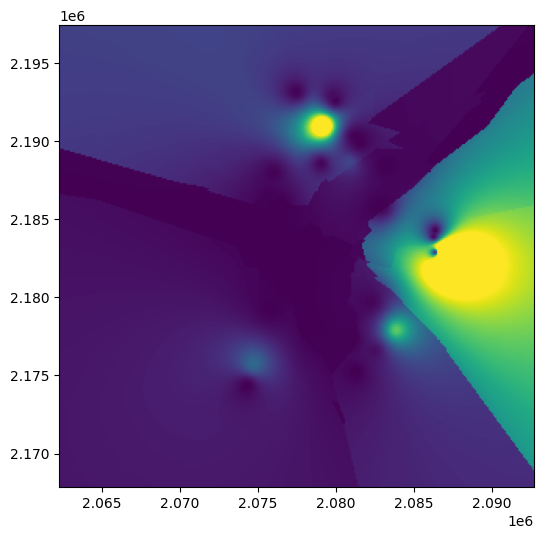

In [293]:
coords = test.get_coordinates().to_numpy()
values = test["release"].to_numpy()

interp = ShepardIDWInterpolator(coords, values)

xmin = df.total_bounds[0]
xmax = df.total_bounds[2]
ymin = df.total_bounds[1]
ymax = df.total_bounds[3]

cell_size = 100
num_x = int((xmax - xmin) / cell_size)
num_y = int((ymax - ymin) / cell_size)

xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, num_x),
    np.linspace(ymin, ymax, num_y),
)

coords_eval = np.vstack([xx.ravel(), yy.ravel()]).T
z = interp(coords_eval, power=2).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(
    z,
    vmin=0,
    vmax=test["release"].quantile(0.95),
    origin="lower",
    extent=(xmin, xmax, ymin, ymax),
    cmap="viridis",
)

transform = rio_transform.from_bounds(xmin, ymin, xmax, ymax, z.shape[1], z.shape[0])
with rio.open(
    "test.tif",
    "w",
    driver="GTiff",
    height=z.shape[0],
    width=z.shape[1],
    count=1,
    dtype=z.dtype,
    crs="EPSG:6372",
    transform=transform,
    compress="lzw"
) as dst:
    dst.write(np.flip(z, 0), 1)

In [296]:
contaminants = {}
with rio.open("./test.tif",) as ds:
    for idx, geom in df["geometry"].items():
        masked, _ = rio_mask.mask(ds, [geom], crop=True, nodata=np.nan)
        contaminants[idx] = np.nanmean(masked)

df_contaminants = (
    df
    .assign(
        total_contaminants=pd.Series(contaminants),
        contaminants_per_sqkm=lambda df: df["total_contaminants"] / (df.geometry.area / 1e6),
        contaminants_per_capita=lambda df: df["total_contaminants"] / df["POBTOT"],
    )
)

rows["kg_contaminantes_por_km2"] = df_contaminants["contaminants_per_sqkm"]

/var/folders/yq/0mz24vy927s9m5vjh6gqb6040000gn/T/ipykernel_23473/1846180560.py:5: RuntimeWarning: Mean of empty slice
  contaminants[idx] = np.nanmean(masked)
/var/folders/yq/0mz24vy927s9m5vjh6gqb6040000gn/T/ipykernel_23473/1846180560.py:5: RuntimeWarning: Mean of empty slice
  contaminants[idx] = np.nanmean(masked)
/var/folders/yq/0mz24vy927s9m5vjh6gqb6040000gn/T/ipykernel_23473/1846180560.py:5: RuntimeWarning: Mean of empty slice
  contaminants[idx] = np.nanmean(masked)
/var/folders/yq/0mz24vy927s9m5vjh6gqb6040000gn/T/ipykernel_23473/1846180560.py:5: RuntimeWarning: Mean of empty slice
  contaminants[idx] = np.nanmean(masked)


<Axes: >

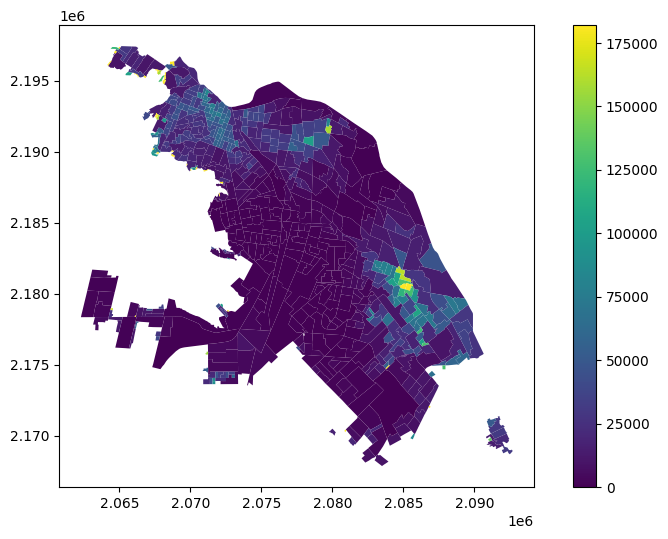

In [297]:
column = "contaminants_per_sqkm"
df_contaminants.plot(
    column=column,
    legend=True,
    figsize=(10, 6),
    vmin=0,
    vmax=df_contaminants[column].quantile(0.95),
    cmap="viridis",
)

Mandar lo de los AGEBs

Mandar los puntos de la industria con unidades

(-1000.0, 100000.0)

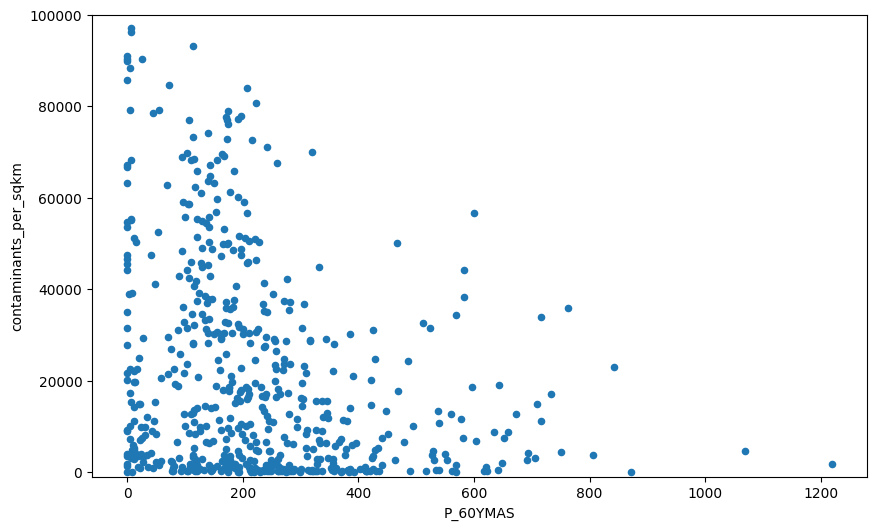

In [298]:
fig, ax = plt.subplots(figsize=(10, 6))
df_contaminants.plot(x="P_60YMAS", y="contaminants_per_sqkm", kind="scatter", ax=ax)
ax.set_ylim(-1000, 1e5)

In [190]:
test_buffered = test.assign(
    radius=lambda df: df["bin"] * 500 + 1000,
    # radius = 3219,
    geometry=lambda df: df["geometry"].buffer(df["radius"]),
)

df_agebs_affected = (
    df_blocks[["geometry", "CVEGEO_AGEB", "P_0A5", "P_60YMAS", "TVIVPARHAB"]]
    .sjoin(test_buffered[["geometry"]], how="inner", predicate="within")
    .reset_index(names="CVEGEO")
    .drop_duplicates(subset="CVEGEO")
    .groupby("CVEGEO_AGEB")
    .agg({"P_0A5": "sum", "P_60YMAS": "sum", "TVIVPARHAB": "sum"})
)

rows["infantes_vulnerables_industria"] = (
    df_agebs_affected["P_0A5"] / df["P_0A5"]
).fillna(0)
rows["adultos_mayores_vulnerables_industria"] = (
    df_agebs_affected["P_60YMAS"] / df["P_60YMAS"]
).fillna(0)
rows["viviendas_vulnerables_industria"] = (
    df_agebs_affected["TVIVPARHAB"] / df["TVIVPARHAB"]
).fillna(0)

# Vulnerabilidad calor

In [299]:
rows["vulnerabilidad_calor"] = (
    gpd.read_file(data_path / "datos" / "GUHVI" / "agebs_GUHVI.gpkg")
    .set_index("cvegeo")["guhvi_class"]
    .astype(int)
)

# Out

In [300]:
out = gpd.GeoDataFrame(
    pd.DataFrame.from_dict(rows, orient="index").transpose().join(df[["geometry"]]),
    crs=df.crs,
    geometry="geometry",
).to_crs("EPSG:4326")

for c in out.columns:
    if not c.startswith("indice") and c != "geometry":
        out[c] = out[c].astype(float)

out = out.drop(
    columns=["tiempo_viaje_hospitales", "tiempo_viaje_preparatorias"], errors="ignore",
)

out.to_file("./agebs.geojson")

[15-09-2025 17:36:18] [pyogrio._io] [INFO] Created 664 records


In [198]:
out["ingreso"]

0803700010401         NaN
0803700010416    6.486524
0803700010435         NaN
0803700010454    6.158248
0803700010469    7.071210
                   ...   
0803706356472    4.457026
0803706356519    3.971397
0803706356523    4.539228
0803706356538         NaN
0803706358549         NaN
Name: ingreso, Length: 664, dtype: float64

<Axes: >

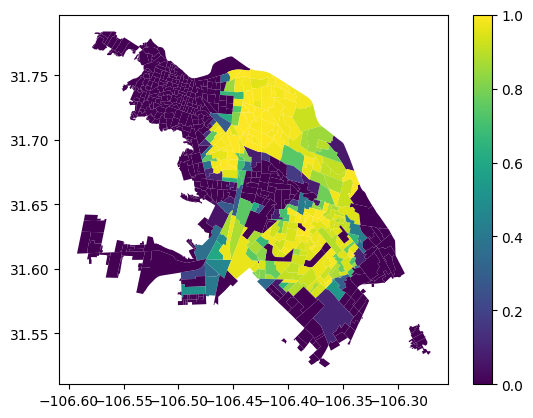

In [196]:
out.plot(column="adultos_mayores_vulnerables_industria", legend=True, categorical=False)